# kaggle Study 45일차(CreditCard)
코드출처 : https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now/data

## Credit card fraud detection
이 노트북은 치우친 데이터에 대해 여러 가지 방법을 테스트합니다. 이 아이디어는 예측 모델의 효율성을 저해할 수 있는 압도적 다수 클래스가 있을 때 사전 처리 기법이 더 잘 작동하는지 비교하는 것입니다.
또한 다른 분류 모델에서 하이퍼 파라미터 튜닝에 교차 검증을 적용하는 방법도 확인할 수 있습니다. 저의 의도는 다음을 사용하여 모델을 만드는 것입니다.
1. 로지스틱 회귀 분석
2. SVM
3. 의사 결정 트리  
  
저도 이상 징후 탐지 기술을 시도해 보고 싶지만, 그래도 좀 더 조사해 봐야 하니 조언해주시면 감사하겠습니다!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Loading the dataset

In [2]:
data = pd.read_csv("C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/CreditCard/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Checking the target classes

Text(0, 0.5, 'Frequency')

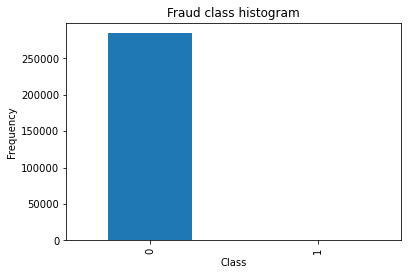

In [3]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

데이터가 완전히 불균형인 것은 분명합니다!!
이것은 일반적인 정확도 점수를 사용하여 분류 알고리즘을 평가하는 명확한 예입니다. 예를 들어, 만일 우리가 단지 다수 클래스를 사용하여 모든 레코드에 값을 할당했다면, 우리는 여전히 높은 정확도를 가질 것입니다. 그러나 우리는 모든 "1"을 잘못 분류할 것입니다!!
이러한 불균형을 고려하여 이 분류 문제에 접근하는 몇 가지 방법이 있습니다.
- 더 많은 데이터를 수집? => 좋은 전략이지만 이 경우에는 해당되지 않습니다.
- 성능 메트릭을 변경합니다.
    - 혼동 행렬을 사용하여 정밀도, 리콜을 계산합니다.
    - F1 점수(정밀 호출의 가중 평균)
    - 카파 사용 : 데이터의 클래스 불균형에 의해 정규화된 분류 정확도
    - ROC 곡선 - 민감도/특이성 비율을 계산합니다.
- 데이터 집합을 다시 샘플링
    - 기본적으로 이 방법은 데이터를 약 50-50 비율로 처리하는 방법
    - 이를 위한 한 가지 방법은 표현되지 않는 클래스의 복사본을 추가하는 오버샘플링을 사용하는 것입니다(데이터가 거의 없을 때 더 좋습니다).
    - 또 다른 것은 언더 샘플링으로, 과도하게 표현된 클래스에서 인스턴스를 삭제합니다(데이터가 많을 경우 더 좋음)

## Approach
1. 우리는 우선 기능 엔지니어링을 수행하지 않을 것입니다. 데이터 세트는 30개의 기능(28개의 익명 + 시간 + 양)을 포함하도록 다운그레이드되었습니다.
2. 그런 다음 재샘플링을 사용할 때와 사용하지 않을 때의 상황을 비교합니다. 간단한 로지스틱 회귀 분석 분류기를 사용하여 이 방법을 테스트합니다.
3. 위에서 언급한 몇 가지 성능 메트릭을 사용하여 모델을 평가합니다.
4. 로지스틱 회귀 분석 분류기의 모수를 조정하여 최적의 재샘플링/비샘플링 방법을 반복합니다.
5. 마지막으로 다른 분류 알고리즘을 사용하여 분류 모델을 수행하겠습니다.
  
## Setting our input and target variables + resampling.

__1. 양 열을 정규화합니다. 양 열이 익명화된 형상과 일치하지 않습니다.__

In [4]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


2. X와 Y를 할당하고 다시 샘플링하지 않는 것
3. 다시 샘플링.
- 앞에서 언급했듯이, 치우친 데이터를 다시 샘플링하는 몇 가지 방법이 있습니다. 언더 샘플링과 오버 샘플링 외에도, SMOTE(Synthetic Minor Over-Sampling Technology)라는 매우 인기 있는 접근법이 있는데, 이는 오버샘플링과 언더샘플링을 결합한 것이지만 오버샘플링 접근법은 소수 클래스를 복제하는 것이 아니라 알고리즘을 통해 새로운 소수 클래스 데이터 인스턴스를 구성하는 것입니다.

- 이 노트북에서는 기존의 언더 샘플링 방식을 사용합니다. 저는 아마 향후 버전의 코드에서 SMOTE를 구현하려고 노력할 것이지만, 현재로서는 기존의 언더샘플릭을 사용할 것입니다.

- 데이터 세트를 표본으로 추출하는 방법은 50/50 비율을 만드는 것입니다. 이 작업은 다수 클래스에서 랜덤하게 "x"의 샘플 양을 선택하여 소수 클래스에서 총 레코드 수를 "x"로 지정합니다.

In [5]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'normAmount'],
      dtype='object')

In [6]:
X = data.drop('Class',axis=1)
y = data['Class']

In [7]:
# 소수 계층 데이터 포인트 수
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# 정상수업 지수를 고르기
normal_indices = data[data.Class == 0].index

# 저희가 고른 지수 중에서 무작위로 "x" 숫자를 선택(number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# 지수 2개를 추가
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# 언더 샘플 데이터셋
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.drop('Class',axis=1)
y_undersample = under_sample_data['Class']

# 비율을 표시
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


## Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [8]:
from sklearn.model_selection import train_test_split

# 전체 데이터셋
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# 언더샘플된 데이터셋
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


## Logistic regression classifier - Undersampled data
리콜 점수가 가장 부정한 트랜잭션을 캡처하는 데 도움이 되는 메트릭이기 때문에, 리콜 점수에 매우 관심이 있습니다. 정밀도, 정밀도 및 리콜이 혼돈 행렬에 어떻게 작용하는지 알고 있는 경우 리콜이 가장 흥미로울 수 있습니다.

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)  
  
__아시다시피, 데이터의 불균형으로 인해 많은 관측치가 거짓 부정으로 예측될 수 있습니다. 즉, 정상적인 트랜잭션을 예측하지만, 실제로는 부정 트랜잭션입니다. 리콜이 이를 캡처합니다.__  
  
- 분명히, 리콜을 늘리려고 하면 정밀도가 떨어지는 경향이 있습니다. 하지만, 우리의 경우, 만약 우리가 거래가 사기성이 있다고 예측하고 그렇지 않다고 밝혀진다면, 그 반대와 비교해 볼 때, 큰 문제는 아닙니다.
- FN과 FP의 오류 유형별로 가중치가 다른 경우 비용 함수를 적용할 수도 있지만, 일단은 생략하겠습니다.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

#### K_fold_cores를 인쇄하기 위한 매우 특별한 기능

In [20]:
def printing_kfold_scores(x_train_data, y_train_data):
    fold = KFold(5,shuffle=False)
    
    # Different C params
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    result_table = pd.DataFrame(index=range(len(c_param_range),2), columns=['C_parameter', 'Mean recall score'])
    result_table['C_parameter'] = c_param_range
    
    # k-fold는 2개의 리스트 제공: train_indices=indices[0], test_indices=indices[1]
    j = 0
    for c_param in c_param_range:
        print('-'*30)
        print('C parameter: ', c_param)
        print('-'*30)
        print('')
        
        recall_accs = []
        for iteration, indices in enumerate(fold.split(x_train_data), start=1):
            # 특정 C 파라미터를 가진 로지스틱 회귀 모형 호출
            lr = LogisticRegression(C = c_param, penalty='l2')
            
            # 폴드된 훈련 데이터를 사용하여 모델 훈련
            # 모델을 가지고 예측
            lr.fit(x_train_data.iloc[indices[0],:], y_train_data.iloc[indices[0],:].values.ravel())
            
            # 훈련 데이터의 테스트 인덱스를 사용하여 값 예측
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            # recall score 계산 후 현재 C값과 리스트에 추가
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,
                                      y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration, ': recall score = ', recall_acc)
            
        # recall score의 평균 저장
        result_table.loc[j, 'Mean recall score'] = np.mean(recall_acc)
        j += 1
        print('')
        print('Mean recall score', np.mean(recall_accs))
        print('')
        
    best_c = result_table.iloc[result_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
    
    # 최종적으로, 가장 최고의 C 파라미터 확인
    print('*'*30)
    print('Best model to choose from cross validation is with C parameter=', best_c)
    return best_c

In [21]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

------------------------------
C parameter:  0.01
------------------------------



IndexingError: Too many indexers

#### 혼동 행렬을 표시하는 함수를 만들기

In [14]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    이 함수는 혼동 행렬을 인쇄하고 표시합니다.
    'normalize=True'를 설정하여 정규화를 적용할 수 있습니다.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')

    #print(cm)

        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

__테스트 세트 예측 및 혼동 행렬 표시__  
  
__우리는 우리의 예측 모델이 얼마나 효과적인지에 대한 우리의 대리인으로서 리콜 메트릭을 사용하는 것에 대해 말해왔습니다. 리콜이 여전히 계산하고자 하는 리콜이지만, 표본이 부족한 데이터가 특정 클래스에 대한 왜곡이 없다는 점을 명심하십시오. 따라서 리콜 메트릭이 매우 중요하지는 않습니다.__

In [15]:
# 이 C_params를 사용하여 전체 교육 데이터 집합으로 최종 모델을 구축하고 테스트의 클래스를 예측합니다.
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# confuse matrix 계산
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 비표준화된 confuse matrix 그리기
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

NameError: name 'best_c' is not defined

__따라서 이 모델은 일반화된 보이지 않는 데이터(테스트 세트)에 대해 93.2%의 회수 정확도를 제공합니다. 첫 번째 시도에는 나쁘지 않은 비율입니다. 그러나 이 값은 언더샘플링 테스트 세트에서 93.2%의 리콜 정확도 측도를 나타냅니다.__  
  
__이 결과에 만족하면서 적합 모형을 적용하여 전체 데이터에 대해 테스트해 보겠습니다.__

In [16]:
# 이 C_params를 사용하여 전체 교육 데이터 집합으로 최종 모델을 구축하고 테스트의 클래스를 예측합니다.
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# confuse matrix 계산
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 비표준화된 confuse matrix 그리기
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

NameError: name 'best_c' is not defined

__훨씬 크고 치우쳐 있는 데이터 세트에 적용해도 회수 정확도는 매우 뛰어납니다!__
__초기 접근 방식이 어떻게 작동하는지에 대해 만족하기 시작할 수 있습니다.__
#### Plotting ROC curve and Precision-Recall curve
- 저는 이 경우에 정밀 리콜 곡선이 훨씬 더 편리하다고 생각합니다. 왜냐하면 우리의 문제는 음수 등급보다 "양수" 등급에 의존하기 때문입니다. 하지만 우리가 회수 정밀도를 계산했기 때문에, 저는 아직 정밀 리콜 곡선을 그리지는 않을 것입니다.

- AUC 및 ROC 곡선도 모형이 전체적으로 정확하게 예측하고 많은 오차를 만들지 여부를 확인하는 데 유용합니다.

In [17]:
# ROC 곡선
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# ROC 그리기
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'best_c' is not defined

흥미로운 추가 설명은 샘플이 부족한 여러 데이터 세트를 초기화하고 프로세스를 반복하는 것입니다. 언더샘플 데이터를 생성하기 위해 대부분의 클래스에서 랜덤하게 레코드를 얻었습니다. 이 매개 변수가 유효한 기술이지만 실제 모집단을 나타내지 않으므로 서로 다른 언더샘플 구성으로 프로세스를 반복하고 이전에 선택한 매개 변수가 여전히 가장 효과적인지 확인하는 것이 좋습니다. 결국, 아이디어는 전체 데이터 세트의 더 넓은 무작위 표현을 사용하고 평균적인 최상의 매개 변수에 의존하는 것입니다.
## Logistic regression classifier - Skewed data
__이전의 접근 방식을 테스트해 본 결과, 왜곡된 데이터에 대해 동일한 프로세스를 테스트하는 것이 매우 흥미롭습니다. 우리의 직관은 왜성이 포착하기 어려운 문제를 야기하여 덜 효과적인 알고리듬을 제공할 것이라는 것입니다.__
- 공정하게 말하자면, 열차와 시험 데이터 세트가 미샘플링 데이터 세트보다 상당히 크다는 사실을 고려하면, K-폴드 교차 검증이 필요하다고 생각합니다. 교육 세트의 60%로 데이터를 분할하면 20%의 교차 검증과 20%의 테스트가 충분할 것으로 생각합니다. 하지만 이전과 동일한 방식을 취하도록 하겠습니다(이러한 문제 없이 K-폴드가 계산적으로 더 비쌉니다).

In [18]:
best_c = printing_Kfold_scores(X_train,y_train)

------------------------------
C parameter:  0.01
------------------------------



IndexingError: Too many indexers

In [19]:
# 이 C_params를 사용하여 전체 교육 데이터 집합으로 최종 모델을 구축하고 테스트의 클래스를 예측합니다.
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# confuse matrix 계산
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 비표준화된 confuse matrix 그리기
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

NameError: name 'best_c' is not defined

__따라서 이 모델은 일반화된 보이지 않는 데이터(테스트 세트)에 대해 93.2%의 회수 정확도를 제공합니다. 첫 번째 시도에는 나쁘지 않은 비율입니다. 그러나 이 값은 언더샘플링 테스트 세트에서 93.2%의 리콜 정확도 측도를 나타냅니다.__  
  

__이 결과에 만족하면서 적합 모형을 적용하여 전체 데이터에 대해 테스트해 보겠습니다.__

In [ ]:
# 이 C_params를 사용하여 전체 교육 데이터 집합으로 최종 모델을 구축하고 테스트의 클래스를 예측합니다.lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# confuse matrix 계산
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 비표준화된 confuse matrix 그리기
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## 계속하기 전에... 분류 임계값을 변경합니다.
__우리는 데이터를 과소 샘플링함으로써 우리의 알고리즘이 사기를 탐지하는 데 훨씬 더 효과적이라는 것을 보아 왔습니다. 또한 임계값을 변경하여 최종 분류를 어떻게 조정할 수 있는지 보여드리고 싶었습니다.__
- 처음에는 분류 모형을 만든 다음 이를 사용하여 보이지 않는 데이터를 예측합니다.
- 이전에 "예측()" 방법을 사용하여 레코드가 "1"에 속해야 하는지 "0"에 속해야 하는지 여부를 결정했습니다.
- 다른 방법 "pedict_proba()"가 있습니다.
    - 이 메서드는 각 클래스에 대한 확률을 반환합니다. 클래스 1에 레코드를 할당하기 위해 임계값을 변경하면 정밀도와 호출을 제어할 수 있습니다.  
      
__언더샘플링된 데이터를 사용하여 확인하겠습니다(베스트 C_param = 0.01)__

In [ ]:
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

__이 패턴은 매우 명확합니다. 클래스 "1" 범주에 특정 값을 입력하는 데 필요한 확률을 낮출수록 해당 버킷에 더 많은 레코드가 들어갑니다.__  

__이는 리콜 증가(모든 "1"을 원하지만 동시에 정밀도 감소)를 의미합니다(많은 다른 클래스를 잘못 분류함).__  

__따라서 리콜이 목표 메트릭이지만(사기 트랜잭션을 놓치지 않음), 전체적으로 정확한 모델을 유지하고자 합니다.__
- 이 문제를 해결하는 데는 꽤 흥미로운 방법이 있을 것 같습니다. 잘못된 분류에 비용을 할당할 수 있지만, "1s"를 올바르게 분류하는 데 관심이 있는 경우 "1s"를 잘못 분류하는 데 드는 비용은 "0"보다 커야 합니다. 그런 다음 알고리즘은 총 비용을 최소화하는 임계값을 선택합니다. 단점은 각 비용의 가중치를 수동으로 선택해야 한다는 것입니다. 그러므로, 나는 이것을 생각하여 남길 것입니다.
- 임계값 변경으로 돌아가면 Precision-Recall 곡선이라는 옵션이 있습니다. 선택한 임계값에 따라 모델의 성능을 시각적으로 확인함으로써 높은 정밀도 값을 유지하면서 리콜이 충분히 높은 단점을 조사할 수 있습니다.  
  
__정밀도-호출 곡선과 이 곡선 아래의 영역을 조사합니다.__

In [ ]:
from itertools import cycle

lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

### Upcoming updates:
### testing SVMs
### testing decision trees